In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

In [192]:
def r_adjusted(r_squared, X, y):
    return 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

# Initial Inspection

In [193]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [194]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [195]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [196]:
"""
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
"""

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [197]:
# From looking at the map, we found some waterfont properties labeled as NAs that had a water front view.
# Correctly assigning the NAs, requires a deeper analysis. 
# Se decided to drop this column
#df = df.drop(columns=["waterfront"])

In [198]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [199]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [200]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [201]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [202]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [203]:
# Looking for outliers

In [204]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [205]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [206]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

#### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [207]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [208]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

## Modelling whole data set

In [209]:
columns_to_drop = ['id', 'date']
#columns_to_drop = ['id', 'zipcode','lat','long',\
#                   'date', 'sqft_basement' , 'yr_renovated','price_per_sqft', 'blt_or_renov']
# We are removing these columns as the seller is not is control of this variables


In [210]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [211]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement,blt_or_renov,price_per_sqft
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340,5650,0,0,1955.0,188.050847
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,1991.0,98125,47.7210,-122.319,1690,7639,1,1,1991.0,209.338521
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720,8062,0,0,1933.0,233.766234
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360,5000,0,1,1965.0,308.163265
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800,7503,0,0,1987.0,303.571429


In [212]:
# Dropping additional columns
# year_bought is all effectively 2014 and 2015. 
# sqft_living15 and sqft_lot15 only has correlations to sqft, 
# which is a more representative variable
#more_cols_to_drop = ['year_bought', 'sqft_lot15', 'sqft_living15']

In [213]:
#df.drop(more_cols_to_drop, axis=1, inplace=True)

# Standardize the data

In [214]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_living_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_living_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['sqft_living15']
sqft_living15_min = min(b)
sqft_living15_range = max(b)-min(b)
df['sqft_living15'] = (b-sqft_living15_min)/sqft_living15_range

b = df['sqft_lot15']
sqft_lot15_min = min(b)
sqft_lot15_range = max(b)-min(b)
df['sqft_lot15'] = (b-sqft_lot15_min)/sqft_lot15_range

b = df['sqft_basement']
sqft_basement_min = min(b)
sqft_basement_range = max(b)-min(b)
df['sqft_basement'] = (b-sqft_basement_min)/sqft_basement_range

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

b = df['yr_renovated']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_renovated'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [215]:
zip_dummy = pd.get_dummies(df["zipcode"], prefix="ZIP")
df = df.drop(columns=["zipcode"],)
df = pd.concat([df, zip_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [216]:
wf_dummy = pd.get_dummies(df["waterfront"], prefix="WF")
df = df.drop(columns=["waterfront"],)
df = pd.concat([df, wf_dummy], axis=1)

In [217]:
view_dummy = pd.get_dummies(df["view"], prefix="VIEW")
df = df.drop(columns=["view"],)
df = pd.concat([df, view_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [218]:
condition_dummy = pd.get_dummies(df["condition"], prefix="COND")
df = df.drop(columns=["condition"],)
df = pd.concat([df, condition_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [219]:
grade_dummy = pd.get_dummies(df["grade"], prefix="GRADE")
df = df.drop(columns=["grade"],)
df = pd.concat([df, grade_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [220]:
print_NAs(df)

Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


In [221]:
df.drop("yr_renovated", axis=1, inplace=True)

In [57]:
#from sklearn.cluster import SpectralClustering
#model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
#                           assign_labels='kmeans')
#labels = model.fit_predict(X)

In [222]:
#Lets select our predictor data frame
X = df.drop(columns=['price', "price_per_sqft"])

In [223]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [224]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=.5)
linreg.fit(X_train, y_train)
#model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()
#model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [225]:
linreg.score(X_train, y_train)

0.8803890832971175

In [226]:
r_squared = linreg.score(X_train, y_train)

adj = r_adjusted(r_squared, X, y)

In [227]:
adj

0.879810257959204

In [228]:
from sklearn.metrics import r2_score
y_predict = linreg.predict(X_test)

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Predicted vs. measured price')

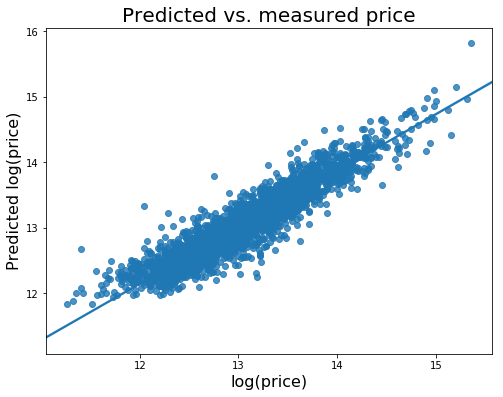

In [229]:
fig = plt.figure(figsize=(8,6))
sns.regplot(y_test, y_predict)
plt.xlabel('log(price)', fontsize=16)
plt.ylabel('Predicted log(price)',fontsize=16)
plt.title('Predicted vs. measured price',fontsize=20)

In [230]:
r2_score(y_predict, y_test)

0.8527972248345168

In [231]:
y_predict_train = linreg.predict(X_train)
print(r2_score(y_predict_train, y_train))
print(r2_score(y_predict, y_test))

0.8637353484826884
0.8527972248345168


In [232]:
y_predict_train = linreg.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033151077362593505
Test Mean Squarred Error: 0.03465916497848277
1.0454913606394869


In [233]:
model_results = []
model_results.append(["Ridge - alpha .5", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [234]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [235]:
lasso.score(X_train, y_train)

0.01140596049312148

In [236]:
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.27399637413782585
Test Mean Squarred Error: 0.03465916497848277
0.12649497675851906


In [237]:
#adj = r_adjusted(lasso.score(X_train, y_train), X, y)
#model_results.append(["Lasso - alpha 1", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [238]:
lasso = Lasso(alpha=.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [239]:
lasso.score(X_train, y_train)

0.8475744804164979

In [240]:
r2_score(y_predict, y_test)

0.8527972248345168

In [241]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [242]:
alphas = np.logspace(-4, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)

In [243]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.0001 , 0.00013, 0.00016, 0.0002 , 0.00026, 0.00033, 0.00042,
       0.00053, 0.00067, 0.00085, 0.00108, 0.00137, 0.00174, 0.00221,
       0.00281, 0.00356, 0.00452, 0.00574, 0.00728, 0.00924, 0.01172,
       0.01487, 0.01887, 0.02395, 0.03039, 0.03857, 0.04894, 0.0621 ,
       0.0788 , 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

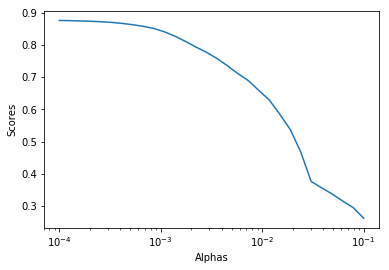

In [244]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [245]:
lasso = Lasso(alpha=.0001)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

0.8789528379389232

In [246]:
from sklearn.metrics import mean_squared_error
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03354914371216786
Test Mean Squarred Error: 0.03465916497848277
1.033086426164502


In [247]:
adj = r_adjusted(lasso.score(X_train, y_train), X_train, y_train)
model_results.append(["Lasso - alpha .0001", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [248]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [249]:

alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [250]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

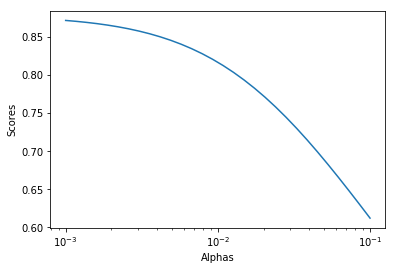

In [251]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [252]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001)
elastic.fit(X_train, y_train)

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [253]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03339387974476995
Test Mean Squarred Error: 0.03465916497848277
1.0378897343879605


In [254]:
elastic.score(X_train, y_train)

0.879513038902176

In [255]:
L1_ratios = np.linspace(0, 1, 3)

tuned_parameters = [{'l1_ratio': L1_ratios}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [256]:
clf.fit(X_train, y_train)

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'l1_ratio': array([0. , 0.5, 1. ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

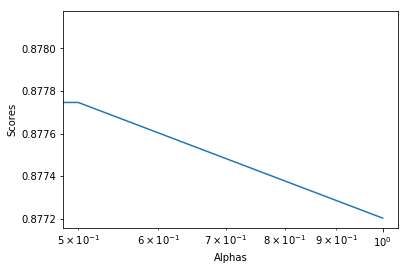

In [104]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(L1_ratios, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [257]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [258]:
elastic.score(X_train, y_train)

0.879945996149153

In [259]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033273882343321334
Test Mean Squarred Error: 0.03465916497848277
1.0416327322693526


In [260]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="neg_mean_squared_error")

In [261]:
cvs

array([-0.03244956, -0.03132973, -0.03415875, -0.03775446, -0.03106247,
       -0.03549044, -0.03360354, -0.03358137, -0.03188934, -0.03484737,
       -0.03595807, -0.03329514, -0.03103544, -0.03204476, -0.03931689,
       -0.03761678, -0.03386088, -0.03520486, -0.03392449, -0.03347775])

In [262]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="r2")

In [263]:
print('average score after CV: {0:0.3f} std {1:0.3f}'.format(cvs.mean(), cvs.std()))

average score after CV: 0.877 std 0.008


In [264]:
lasso.coef_

array([-1.29522764e-03,  4.15327964e-02,  1.22900051e+00,  7.93074326e-01,
       -3.05340905e-02,  1.10502717e+00,  0.00000000e+00, -1.23009599e-01,
        1.21334096e+00, -3.89542503e-01,  4.65679064e-01,  2.42694791e-02,
        5.92358525e-02,  4.41190748e-02,  2.04553279e-04, -2.59875813e-01,
       -2.55094599e-01, -2.72372989e-01,  4.54411081e-01,  9.26530960e-02,
        9.10905525e-02,  3.22893732e-02,  4.72126236e-02,  3.01891951e-02,
       -3.44937315e-01, -1.95384559e-01, -3.25660392e-01,  0.00000000e+00,
       -3.41721972e-01, -0.00000000e+00,  5.73422428e-02, -3.94799867e-01,
        9.91714904e-02, -2.50795713e-01, -2.76003897e-01, -3.65805934e-01,
        7.25666531e-02, -2.08828058e-01, -7.71322778e-02,  5.37651802e-01,
        2.82047580e-01, -2.16144783e-01,  5.03617250e-02, -4.14179963e-02,
       -4.86032452e-02, -2.95541106e-01, -1.73192022e-01, -2.28222491e-01,
       -1.11552871e-01,  0.00000000e+00, -1.12561025e-01, -2.60642950e-01,
       -2.84237244e-02,  

In [265]:
coefs = list(zip(lasso.coef_, X_train.columns))

In [266]:
coefs = [x for x in coefs if "ZIP" in x[1]]

In [267]:
coefs.sort(key=lambda x: x[0])

In [268]:
coefs

[(-0.4107887598091517, 'ZIP_98168'),
 (-0.404775309279981, 'ZIP_98155'),
 (-0.39479986651167764, 'ZIP_98028'),
 (-0.36696622305370724, 'ZIP_98133'),
 (-0.3658059343575576, 'ZIP_98032'),
 (-0.344937315152515, 'ZIP_98011'),
 (-0.34172197227146633, 'ZIP_98023'),
 (-0.3407183597652291, 'ZIP_98188'),
 (-0.33692760624739787, 'ZIP_98178'),
 (-0.32883951257136196, 'ZIP_98198'),
 (-0.3256603917854592, 'ZIP_98019'),
 (-0.29554110614198326, 'ZIP_98055'),
 (-0.27600389726969443, 'ZIP_98031'),
 (-0.27237298888663936, 'ZIP_98003'),
 (-0.26878056907272374, 'ZIP_98077'),
 (-0.26337763844195783, 'ZIP_98148'),
 (-0.26064295005741867, 'ZIP_98072'),
 (-0.2598758130882497, 'ZIP_98001'),
 (-0.25852320524916983, 'ZIP_98177'),
 (-0.2561819959773934, 'ZIP_98146'),
 (-0.25509459881753493, 'ZIP_98002'),
 (-0.2525578749650853, 'ZIP_98106'),
 (-0.25079571338819395, 'ZIP_98030'),
 (-0.23157044826197687, 'ZIP_98108'),
 (-0.22822249133352418, 'ZIP_98058'),
 (-0.21614478277620444, 'ZIP_98042'),
 (-0.21353061406945856,

In [269]:
adj = r_adjusted(elastic.score(X_train, y_train), X_train, y_train)
model_results.append(["Elastic - alpha=.0001, l1_ratio=.00001", elastic.score(X_train, y_train), adj, train_mse, test_mse])

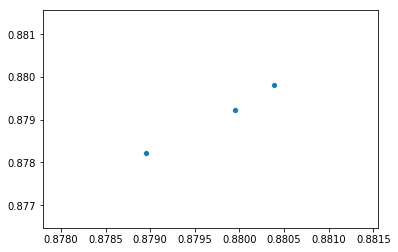

In [270]:


r2 = [x[1] for x in model_results]
r2_adj = [x[2] for x in model_results]
sns.scatterplot(r2, r2_adj)

In [271]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [272]:
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033273882343321334
Test Mean Squarred Error: 0.03465916497848277
1.0416327322693526


In [273]:
linreg.score(X_train, y_train)

0.8805064951878927

In [274]:
adj = r_adjusted(linreg.score(X_train, y_train), X_train, y_train)

In [275]:
model_results.append(["Linear Regression", linreg.score(X_train, y_train), adj, train_mse, test_mse])

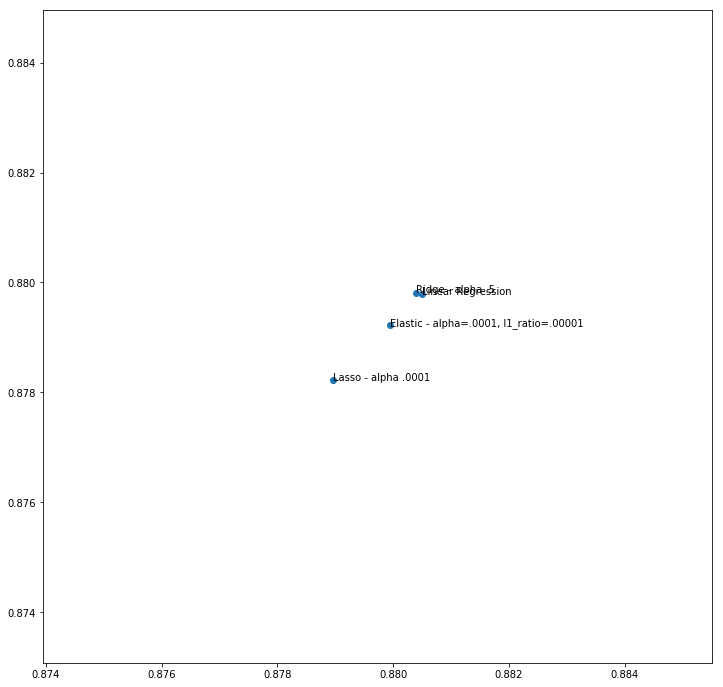

In [276]:


r2 = [x[1] for x in model_results]
r2_adj = [x[2] for x in model_results]
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(r2, r2_adj)

for i, entry in enumerate(model_results):
    ax.annotate(entry[0], (r2[i], r2_adj[i]))

#ax.margins(x=0, y=-0.45)


In [277]:
model_results

[['Ridge - alpha .5',
  0.8803890832971175,
  0.879810257959204,
  0.033151077362593505,
  0.03465916497848277],
 ['Lasso - alpha .0001',
  0.8789528379389232,
  0.8782196887423503,
  0.03354914371216786,
  0.03465916497848277],
 ['Elastic - alpha=.0001, l1_ratio=.00001',
  0.879945996149153,
  0.8792188622372965,
  0.033273882343321334,
  0.03465916497848277],
 ['Linear Regression',
  0.8805064951878927,
  0.8797827560637613,
  0.033273882343321334,
  0.03465916497848277]]

In [278]:
print("Ratio of MSEs")
["%s - %s" % (x[0], x[3]/x[4]) for x in model_results]

Ratio of MSEs


['Ridge - alpha .5 - 0.9564880568581059',
 'Lasso - alpha .0001 - 0.9679732253502346',
 'Elastic - alpha=.0001, l1_ratio=.00001 - 0.9600312749594095',
 'Linear Regression - 0.9600312749594095']

In [279]:
coefs = list(zip(lasso.coef_, X_train.columns))

In [280]:
zero_coefs = [x for x in coefs if x[0]==0]

In [281]:
zero_coefs

[(0.0, 'sqft_basement'),
 (0.0, 'ZIP_98022'),
 (-0.0, 'ZIP_98024'),
 (0.0, 'ZIP_98065'),
 (0.0, 'ZIP_98117'),
 (0.0, 'GRADE_3'),
 (-0.0, 'GRADE_8')]

In [282]:
for zero_coef in zero_coefs:
    print('Dropping parameter ' + zero_coef[1])
    X_train.drop(zero_coef[1], axis=1, inplace=True)
    X_test.drop(zero_coef[1], axis=1, inplace=True)

Dropping parameter sqft_basement


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dropping parameter ZIP_98022
Dropping parameter ZIP_98024
Dropping parameter ZIP_98065
Dropping parameter ZIP_98117
Dropping parameter GRADE_3
Dropping parameter GRADE_8


In [287]:
X_train.drop('lat', axis=1, inplace=True)
X_train.drop('long', axis=1, inplace=True)

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [288]:
lasso_reduced = Lasso(alpha=.0001)
lasso_reduced.fit(X_train, y_train)
lasso_reduced.score(X_train, y_train)

0.8608724592006242

In [289]:
lasso_reduced.intercept_

13.75843278363732

In [290]:
coefs_reduced = list(zip(lasso_reduced.coef_, X_train.columns))

In [321]:
for coef in coefs_reduced:
     if 'GRADE' in coef[1]:
        gnum1 = coef[1].split('_')[-1]
#         print(gnum1)
        
        for coef2 in coefs_reduced:
            if 'GRADE' in coef2[1] and coef[1] != coef2[1]:
                gnum2 = coef2[1].split('_')[-1]
#                 print(gnum2)
#                 continue
                if int(gnum2)>int(gnum1):
                
    #                 print(coef[1],'\t',coef2[1])
                    delta_y = -coef[0]+coef2[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', gnum2,'is {0:0.1f}%'.format(price_change))
                if gnum2=='7': 
                    delta_y = -coef[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', int(gnum2)+1,'is {0:0.1f}%'.format(price_change))


changing from  4  to  5 is 2.0%
changing from  4  to  6 is 13.8%
changing from  4  to  7 is 31.8%
changing from  4  to  8 is 48.2%
changing from  4  to  9 is 67.4%
changing from  4  to  10 is 80.4%
changing from  4  to  11 is 84.8%
changing from  4  to  12 is 86.5%
changing from  5  to  6 is 11.6%
changing from  5  to  7 is 29.1%
changing from  5  to  8 is 45.3%
changing from  5  to  9 is 64.1%
changing from  5  to  10 is 76.8%
changing from  5  to  11 is 81.1%
changing from  5  to  12 is 82.8%
changing from  6  to  7 is 15.7%
changing from  6  to  8 is 30.2%
changing from  6  to  9 is 47.1%
changing from  6  to  10 is 58.5%
changing from  6  to  11 is 62.4%
changing from  6  to  12 is 63.9%
changing from  7  to  9 is 27.1%
changing from  7  to  10 is 36.9%
changing from  7  to  11 is 40.3%
changing from  7  to  12 is 41.6%
changing from  9  to  8 is -11.5%
changing from  9  to  10 is 7.8%
changing from  9  to  11 is 10.4%
changing from  9  to  12 is 11.4%
changing from  10  to  8 is -

In [328]:
for coef in coefs_reduced:
     if 'VIEW' in coef[1]:
        gnum1 = coef[1].split('_')[-1]
#         print(gnum1)
        
        for coef2 in coefs_reduced:
            if 'VIEW' in coef2[1] and coef[1] != coef2[1]:
                gnum2 = coef2[1].split('_')[-1]
#                 print(gnum2)
#                 continue
                if float(gnum2)>float(gnum1):
                
    #                 print(coef[1],'\t',coef2[1])
                    delta_y = -coef[0]+coef2[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', gnum2,'is {0:0.1f}%'.format(price_change))
                if gnum2=='3.0': 
                    delta_y = -coef[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', float(gnum2)+1,'is {0:0.1f}%'.format(price_change))

changing from  0.0  to  1.0 is 13.2%
changing from  0.0  to  2.0 is 10.2%
changing from  0.0  to  3.0 is 18.1%
changing from  0.0  to  4.0 is 29.1%
changing from  1.0  to  2.0 is -2.7%
changing from  1.0  to  3.0 is 4.3%
changing from  1.0  to  4.0 is 14.0%
changing from  2.0  to  3.0 is 7.2%
changing from  2.0  to  4.0 is 17.2%


In [342]:
for coef in coefs_reduced:
     if 'COND' in coef[1]:
        gnum1 = coef[1].split('_')[-1]
#         print(gnum1)
        
        for coef2 in coefs_reduced:
            if 'COND' in coef2[1] and coef[1] != coef2[1]:
                gnum2 = coef2[1].split('_')[-1]
#                 print(gnum2)
#                 continue
                if float(gnum2)>float(gnum1):
                
    #                 print(coef[1],'\t',coef2[1])
                    delta_y = -coef[0]+coef2[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', gnum2,'is {0:0.1f}%'.format(price_change))
                if gnum2=='4': 
                    delta_y = -coef[0]
                    price_change = (np.exp(delta_y)-1.0)*100
                    print('changing from ', gnum1, ' to ', int(gnum2)+1,'is {0:0.1f}%'.format(price_change))
        if int(gnum1)==4:
            delta_y = -coef[0]
            price_change = (np.exp(delta_y)-1.0)*100
            print('changing from ', gnum1, ' to ', int(gnum1)+1,'is {0:0.1f}%'.format(price_change))    

changing from  1  to  2 is 3.2%
changing from  1  to  3 is 13.8%
changing from  1  to  4 is 17.5%
changing from  1  to  5 is 24.1%
changing from  2  to  3 is 10.3%
changing from  2  to  4 is 13.9%
changing from  2  to  5 is 20.2%
changing from  3  to  4 is 3.3%
changing from  3  to  5 is 9.0%
changing from  4  to  5 is 5.6%


In [343]:
# addet price if it has been renovated
for coef in coefs_reduced:
    if 'is_renovated' in coef[1]:
#         print(coef[0])
        delta_y = coef[0]
        price_change = (np.exp(delta_y)-1.0)*100
        print('Added price after renovating {0:0.1f}%'.format(price_change))

Added price after renovating 7.1%


In [344]:
coefs_reduced

[(-0.004979838276101658, 'bedrooms'),
 (0.043880349453492, 'bathrooms'),
 (1.2535625258635665, 'sqft_living'),
 (0.2822971985713925, 'sqft_lot'),
 (-0.008266215890662558, 'floors'),
 (0.9761267358690179, 'sqft_above'),
 (-0.16247842435174192, 'yr_built'),
 (0.39362398082321737, 'sqft_living15'),
 (-0.0, 'sqft_lot15'),
 (0.06871366631369304, 'is_renovated'),
 (0.06621571582597892, 'has_basement'),
 (-0.000341615447304974, 'blt_or_renov'),
 (-0.5193496468154133, 'ZIP_98001'),
 (-0.5395790947075885, 'ZIP_98002'),
 (-0.5161868273833977, 'ZIP_98003'),
 (0.5261530779413159, 'ZIP_98004'),
 (0.14629972442261427, 'ZIP_98005'),
 (0.075299118683847, 'ZIP_98006'),
 (0.07532010354146122, 'ZIP_98007'),
 (0.08517994853381278, 'ZIP_98008'),
 (-0.24121025063618326, 'ZIP_98010'),
 (-0.0976742150361152, 'ZIP_98011'),
 (-0.14411976896330894, 'ZIP_98014'),
 (-0.1763054523809477, 'ZIP_98019'),
 (-0.5721906908220807, 'ZIP_98023'),
 (-0.02605559259361944, 'ZIP_98027'),
 (-0.13159695238847072, 'ZIP_98028'),
 (